In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from scipy.special import boxcox1p
from scipy import stats
from scipy.stats import norm, normaltest, boxcox_normmax
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

# Global Functions

Reduce Memory usage function from [ASHRAE](https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction#5.-Reducing-Memory-Size)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data Load and Type Resolution

In [3]:
house_train = pd.read_csv("data/train.csv")
house_test = pd.read_csv("data/test.csv")
sorted(house_train.columns)

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'BedroomAbvGr',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Fireplaces',
 'Foundation',
 'FullBath',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'Id',
 'KitchenAbvGr',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotArea',
 'LotConfig',
 'LotFrontage',
 'LotShape',
 'LowQualFinSF',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'Neighborhood',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PavedDrive',
 'PoolArea',
 'PoolQC',
 'RoofMatl',
 'RoofStyle

In [4]:
response = 'SalePrice'

Don't need Id column for training

In [5]:
house_train = reduce_mem_usage(house_train)
house_test = reduce_mem_usage(house_test)

Mem. usage decreased to  0.57 Mb (36.4% reduction)
Mem. usage decreased to  0.57 Mb (35.8% reduction)


Change all object columns to category dtype. From [this post](https://stackoverflow.com/questions/39904889/pandas-cast-all-object-columns-to-category)

In [6]:
house_train = pd.concat([
    house_train.select_dtypes([], ['object']),
    house_train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
    ], axis=1)

house_test = pd.concat([
    house_test.select_dtypes([], ['object']),
    house_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
    ], axis=1)

Change columns that have numbers for categories to category type columns

In [7]:
num_cats = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'GarageYrBlt']
for col in num_cats:
    house_train[col] = house_train[col].astype('category')
    house_test[col] = house_test[col].astype('category')

## Missing Data

In [8]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [9]:
missing_data(house_train).head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479


In [10]:
missing_data(house_test).head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461


### Handle missing values for features where median/mean or most common value doesn't make sense
Notice that the columns that have missing values are all categorical except for `LotFrontage`

Change missing values into 'NA' category since having a missing data point for these categories mean NA

In [11]:
def fill_na(df, col, test=False):
    medians = df.median()
    if df[col].isnull().any():
        if pd.api.types.is_categorical_dtype(df[col]):
            value = 'NA'
            if col in ['Condition1', 'Condition2']:
                value = 'Norm'
            elif col == 'CentralAir':
                value = 'N'
            elif col in ['ExterCond', 'ExterQual', 'HeatingQC', 'KitchenQual']:
                value = 'TA'
            elif col == 'Functional':
                value = 'Typ'
            elif col == 'LotShape':
                value = 'Reg'
            elif col == 'MasVnrType':
                value = 'None'
            elif col == 'SaleCondition':
                value = 'Normal'
            elif col == 'Utilities':
                value = 'AllPub'
            elif col in num_cats:
                if not test:
                    # Drop rows from categorical columns with numbers as they don't have NA category
                    df.drop(df[df[col].isnull()].index, inplace=True)
                    return
                else:
                    value = int(medians[col])
            try:
                df[col].cat.add_categories([value], inplace=True)
            except:
                pass
            finally:
                df[col].fillna(value, inplace=True)
        else:
            df[col].fillna(0, inplace=True)

In [12]:
dont_check_cols = ['Id', response]
check_missing_cols = [col for col in house_train.columns if col not in dont_check_cols]

In [13]:
for col in check_missing_cols:
    fill_na(house_train, col)
    fill_na(house_test, col, test=True)

In [14]:
missing_data(house_train).head(3)

,Total,Percent
SaleCondition,0,0.0
Street,0,0.0
BedroomAbvGr,0,0.0


In [15]:
missing_data(house_test).head(3)

,Total,Percent
SaleCondition,0,0.0
SaleType,0,0.0
BedroomAbvGr,0,0.0


## Some Bivariate Analysis

In [16]:
def one_bivariate_plot(df, column, resp_var, add_plot=None):
    typ = df.dtypes[column]
    if pd.api.types.is_numeric_dtype(typ):
        data = pd.concat([df[resp_var], df[column]], axis=1)
        data.plot.scatter(x=column, y=resp_var, figsize=(10, 8))
    else:
        data = pd.concat([df['SalePrice'], df[column]], axis=1)
        f, ax = plt.subplots(figsize=(10, 8))
        fig = sns.boxplot(x=column, y=resp_var, data=data)
    plt.title(f"{column} vs. {resp_var}")
    plt.xticks(rotation=45)
    if add_plot:
        plt.plot(add_plot)

In [17]:
def bivariate_plots(df, resp_var):
    for col in sorted(df.columns):
        one_bivariate_plot(df, col, resp_var)

for col in house_train.columns:
    if pd.api.types.is_int64_dtype(house_train[col]):
        bivariate_scatter_plot(col)

In [18]:
# bivariate_plots(house_train, response)

In [19]:
plt.close('all')

## Correlation Matrix

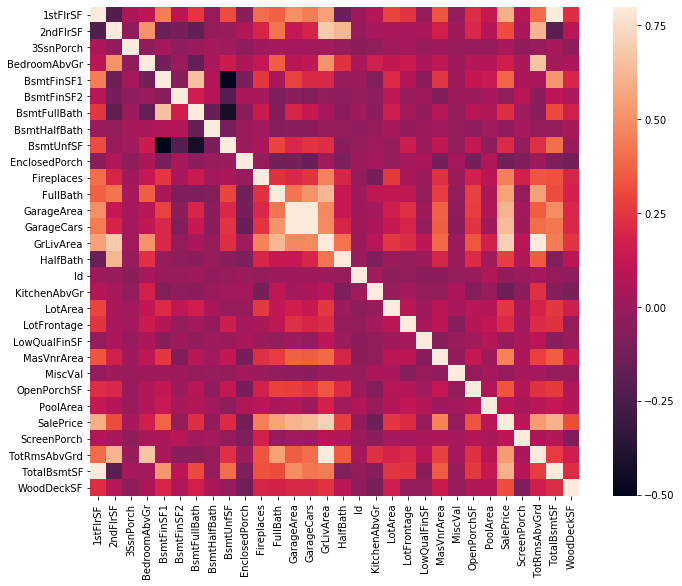

In [20]:
correlation = house_train.corr()
correlation = correlation.reindex(sorted(correlation.columns), axis=1)
correlation.sort_index(inplace=True)

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation, vmax=.8, square=True)

In [21]:
trace = go.Heatmap(
    z = list(reversed(correlation.values.tolist())),
    x = correlation.columns,
    y = correlation.columns[::-1],
    colorscale = 'Viridis',
    zmax = 0.8,
    zmin = -0.5
)

data = [trace]

layout = go.Layout(
    title="Correlation Matrix",
    height=800
)

fig = dict(data=data, layout=layout)
iplot(fig)

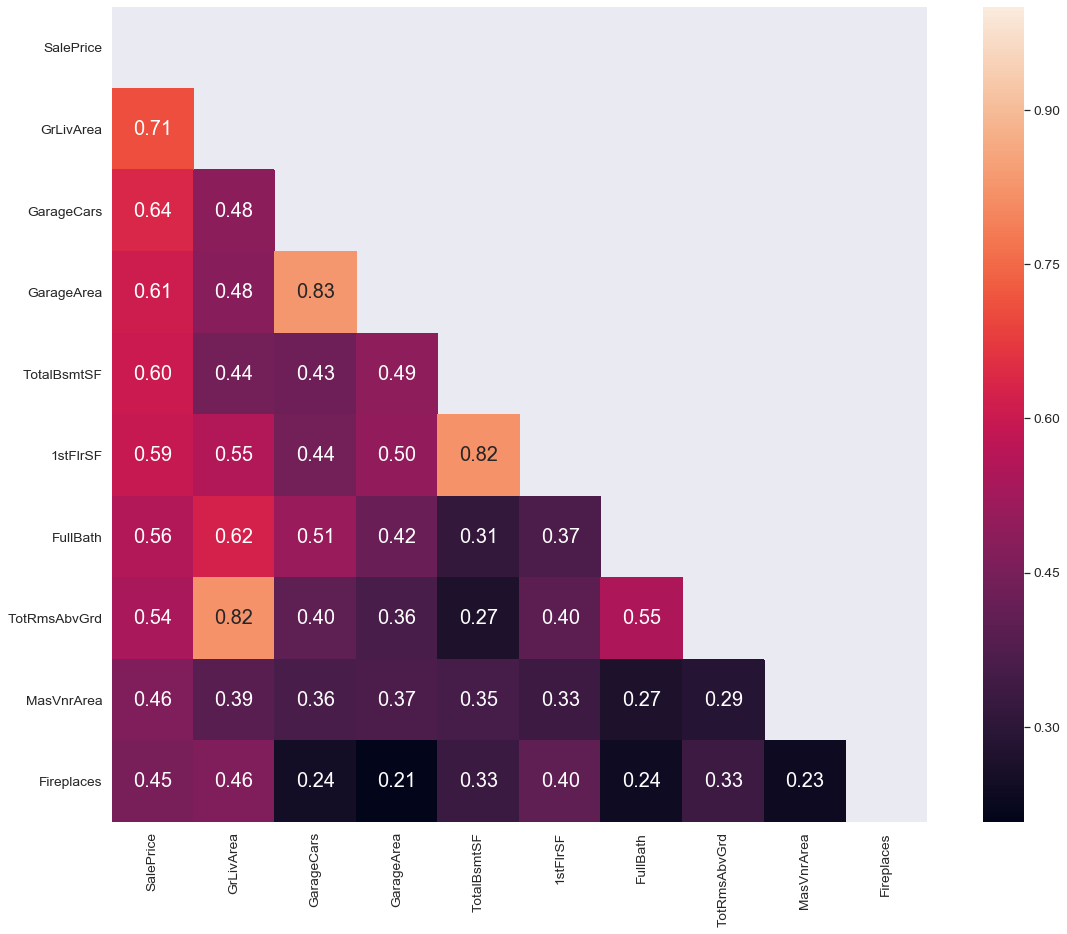

In [22]:
cols = correlation.nlargest(10, response)[response].index
cm = np.corrcoef(house_train[cols].values.T)

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.25)
fig = plt.figure(figsize=(20,15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', mask=mask, annot_kws={'size': 20}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()

In [23]:
fig = ff.create_annotated_heatmap(
    z = list(reversed(np.round(cm, 2))),
    x = cols.values.tolist(),
    y = list(reversed(cols.values.tolist())),

    colorscale = 'Viridis',
    showscale = True,
    hoverinfo = 'skip'
)

fig.update_layout(
    title_text = "Correlation Matrix",
)

fig.update_xaxes(automargin=True)

iplot(fig)

Look at Bivariate plots on the following columns that can possibly be high predictors of Sale Price

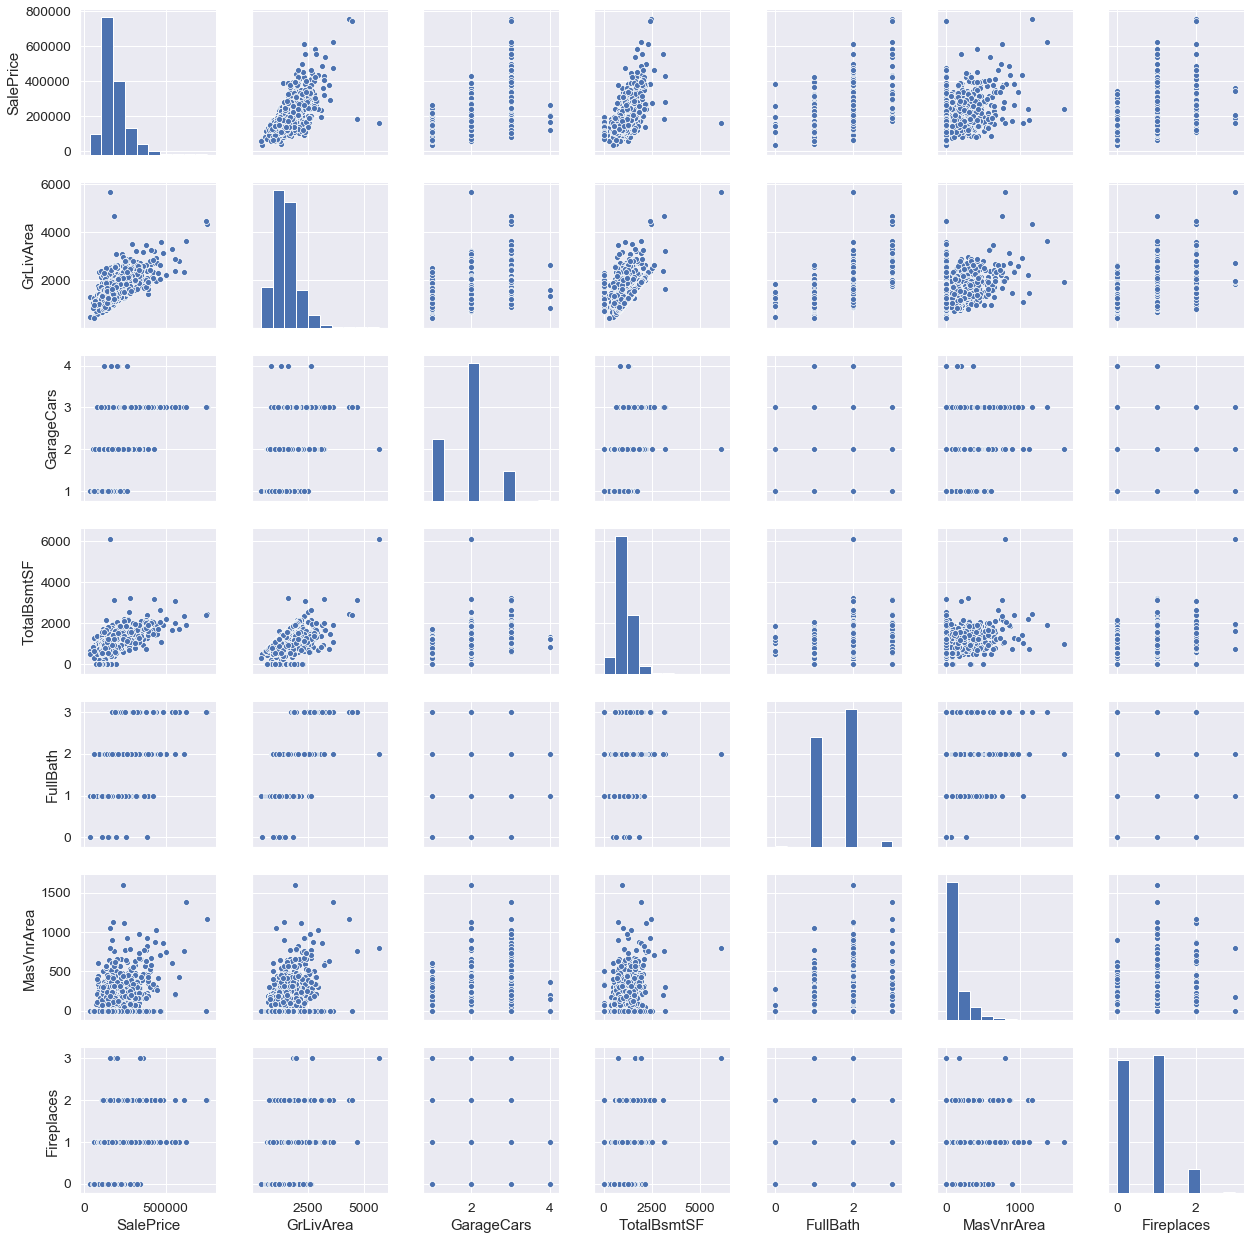

In [24]:
cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'MasVnrArea', 'Fireplaces']
drop_cols = ['GarageArea', '1stFlrSF','TotRmsAbvGrd']
sns.pairplot(house_train[cols], height = 2.5)

Not as useful as Seaborn's pairplots

In [25]:
fig = px.scatter_matrix(house_train[cols])
iplot(fig)

Drop columns deemed redundant (i.e. high correlation)

In [26]:
house_train.drop(drop_cols, axis=1, inplace=True)
house_test.drop(drop_cols, axis=1, inplace=True)

Grab quantitiative and qualitative features

In [27]:
quantitative = [feat for feat in house_train.columns if pd.api.types.is_numeric_dtype(house_train[feat])]
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [feat for feat in house_train.columns if pd.api.types.is_categorical_dtype(house_train[feat])]

In [28]:
quantitative

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [29]:
qualitative

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MoSold',
 'YrSold',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

<b>Check that we have all the columns</b><br>
Quantitative + Qualitative + SalePrice and Id

In [30]:
len(quantitative) + len(qualitative) + 2 == len(house_train.columns)

True

## Exploring Response Variable 'SalePrice'

In [31]:
house_train.SalePrice.describe()

count      1379.00000
mean     185479.51124
std       79023.89060
min       35311.00000
25%      134000.00000
50%      167500.00000
75%      217750.00000
max      755000.00000
Name: SalePrice, dtype: float64

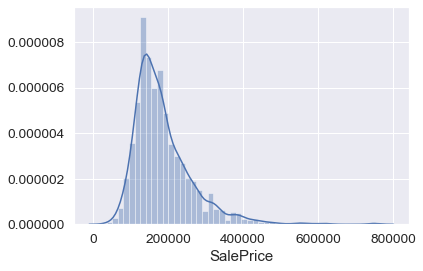

In [32]:
sns.distplot(house_train.SalePrice)

* Not Normally distributed
* Positive Skewness
* Shows peakedness

In [33]:
print(f"Skewness: {round(house_train.SalePrice.skew(), 3)}")
print(f"Kurtosis: {round(house_train.SalePrice.kurt(), 3)}")

Skewness: 1.935
Kurtosis: 6.736


Log Transform response variable to normalize

Skewness: 0.29
Kurtosis: 0.686


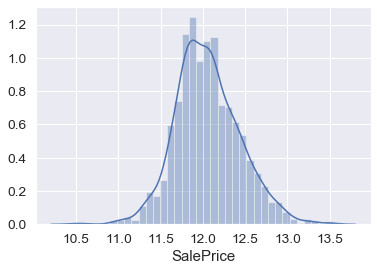

In [34]:
house_train[response] = np.log(house_train[response])

sns.distplot(house_train.SalePrice)
print(f"Skewness: {round(house_train.SalePrice.skew(), 3)}")
print(f"Kurtosis: {round(house_train.SalePrice.kurt(), 3)}")

Deal with outliers

In [35]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    indexes = []
    for col in quantitative + [response]:
        outlier_indexes = df[col][(df[col] < (Q1[col] - 1.5 * IQR[col]))\
                                  | (df[col] > (Q3[col] + 1.5 * IQR[col]))]\
            .nlargest(1).index
        indexes = np.append(indexes, outlier_indexes)
        
    pct_removed = round((len(np.unique(indexes)) / len(house_train)) * 100, 2)
    df.drop(indexes, inplace=True)
    print(f"# of Outliers: {len(np.unique(indexes))}")
    print(f"% of Total removed: {pct_removed}%")

In [36]:
remove_outliers(house_train)

# of Outliers: 20
% of Total removed: 1.45%


## Fixing Skewness

In [37]:
house_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [38]:
def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    new_df = df.copy()

    # Check the skew of all numerical features
    skewed_feats = new_df[quantitative].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        new_df[feat] = boxcox1p(new_df[feat], boxcox_normmax(new_df[feat] + 1))
        
    return new_df
        
linear_train = fixing_skewness(house_train)
linear_test = fixing_skewness(house_test)

In [39]:
linear_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,10.270000,7,5,2003,2003,21.133139,206.991730,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,2,20,80.0,10.434026,6,8,1976,1976,0.000000,266.741981,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,3,60,68.0,10.638722,7,5,2001,2002,19.252766,154.740731,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,4,70,60.0,10.427302,7,5,1915,1970,0.000000,82.113286,...,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,5,60,84.0,10.946393,8,5,2000,2000,27.942017,195.252487,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [40]:
## Calculating Mean Squared Log Error(MSLE) for only guessing the mean SalePrice
house_train['mean_sale_price'] = house_train.SalePrice.mean()
house_train['msle'] = np.square(house_train.mean_sale_price - house_train.SalePrice)

## getting mse
print("Mean Squared Log Error(MSLE) for average line is : {}".format(house_train.msle.mean()))
print("Root Mean Squared Log Error(RMSLE) for average line is : {}".format(np.sqrt(house_train.msle.mean())))

del house_train['mean_sale_price']
del house_train['msle']

Mean Squared Log Error(MSLE) for average line is : 0.14009977015841105
Root Mean Squared Log Error(RMSLE) for average line is : 0.37429903841502327


### One-Hot Encoding

In [41]:
len_train = len(linear_train)
all_data = pd.concat([linear_train.drop(response, axis=1), linear_test], sort=False)

all_data = pd.concat([
    all_data.select_dtypes([], ['object']),
    all_data.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
    ], axis=1)

for col in num_cats:
    all_data[col] = all_data[col].astype('category')
    
all_data = pd.get_dummies(all_data)

train, test = all_data.iloc[:len_train, :], all_data.iloc[len_train:, :]

In [42]:
linear_train = train.drop('Id', axis=1).copy()
linear_test = test.drop('Id', axis=1).copy()

In [43]:
linear_test.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_NA,SaleType_New,SaleType_Oth,SaleType_WD
0,80.0,50.728202,0.000000,86.944466,7.403284,42.300690,367.449982,0.000000,0.0,6.223738,...,0,0,0,0,0,0,0,0,0,1
1,81.0,54.118585,14.471523,137.029541,0.000000,53.961391,520.266235,0.000000,0.0,6.551188,...,0,0,0,0,0,0,0,0,0,1
2,74.0,53.590856,0.000000,123.596191,0.000000,28.085503,383.646057,666.000314,0.0,6.718956,...,0,0,0,0,0,0,0,0,0,1
3,78.0,48.336775,6.114138,102.946342,0.000000,47.173794,382.944458,644.344768,0.0,6.706239,...,0,0,0,0,0,0,0,0,0,1
4,43.0,38.773083,0.000000,58.967327,0.000000,92.848228,503.953705,0.000000,0.0,6.520127,...,0,0,0,0,0,0,0,0,0,1


# Linear Regression

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [45]:
def build_scalar_pipe(model, df):
    # Find non-one-hot-encoded columns and only scale these non-categorical columns
    # Column Transformer
    ct = ColumnTransformer(
        [('scaler', RobustScaler(), quantitative)],
        remainder='passthrough'
    )
    return Pipeline(
        [("transf", ct),
         ("estimator", model)]
    )

In [46]:
model = LinearRegression(n_jobs=-1)

In [47]:
data = linear_train
y = house_train[response]

In [48]:
train_data, val_data, train_target, val_target = train_test_split(data, y, test_size=0.2, random_state=28)

In [49]:
model.fit(train_data, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [50]:
model.coef_

array([-1.15817575e-04,  5.64070605e-02,  1.23647436e-03,  1.26892047e-04,
       -1.26004979e-04, -4.36051261e-04,  3.46700313e-04,  5.59419845e-05,
       -3.10416850e-03,  2.04095799e-01,  2.09975693e-02,  1.63928818e-03,
        3.00705851e-02,  9.49286714e-03, -1.51031638e-02, -1.46910478e-02,
        3.47625465e-02,  3.54145174e-02,  4.27707525e-04,  1.33867314e-03,
        1.18640455e-03,  4.31620447e-03,  2.46547719e-03,  1.35051436e-03,
        1.73494447e-02, -1.91745418e-02, -3.68256418e-02, -1.10111573e-01,
       -2.65561335e-01, -7.81681225e-02, -3.34404820e-02, -8.13940662e-03,
        1.23519459e-01, -8.23119326e-02, -7.89845765e-02,  5.76595816e-02,
       -5.62119368e-02, -9.46887013e-12, -7.77156803e-02, -7.23806713e-02,
        7.37846860e-01,  2.36588700e-12, -3.05641318e-01,  3.83672913e-02,
       -4.32572747e-02, -1.24278375e-02, -5.55648254e-03,  1.40618512e-02,
        5.54047377e-02,  1.31887449e-01,  1.27161583e-01, -1.49025367e-11,
       -4.55341696e-01, -

In [51]:
val_pred = model.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.160145496871277, 13.21491977575629), mean=12.048751758801885, variance=0.11966620683754539, skewness=0.5648270683031336, kurtosis=0.5770221245234448)

In [52]:
from sklearn.metrics import mean_squared_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [53]:
rmsle(val_target, val_pred)

0.1668880889499717

In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

cv = KFold(shuffle=True, random_state=28, n_splits=10)
scores = cross_val_score(model, train_data, train_target, cv=cv, scoring='neg_mean_absolute_error')

In [55]:
print (f"Mean Scores: {np.sqrt(-scores.mean()):.8f}")

Mean Scores: 0.35066582


In [56]:
submission = pd.read_csv("sample_submission.csv"); submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [57]:
submission.SalePrice = np.exp(model.predict(linear_test))
submission.SalePrice

0       7.616751e+05
1       9.286277e+05
2       1.265934e+06
3       9.526900e+05
4       6.214221e+05
            ...     
1454    2.157288e+05
1455    1.516390e+05
1456    1.680036e+06
1457    7.216566e+05
1458    9.842511e+05
Name: SalePrice, Length: 1459, dtype: float64

In [58]:
submission.describe()

,Id,SalePrice
count,1459.000000,1.459000e+03
mean,2190.000000,9.385883e+05
std,421.321334,8.395457e+05
min,1461.000000,1.335443e+05
25%,1825.500000,5.544958e+05
50%,2190.000000,7.729417e+05
75%,2554.500000,1.093077e+06
max,2919.000000,1.864730e+07


In [59]:
submission.to_csv("submission_lr.csv", index=False)

# Elastic Net

In [60]:
from sklearn.linear_model import ElasticNetCV

In [61]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [.1, .5, .7, .8, .85, .9, .95, 1]
kfolds = KFold(n_splits=10, shuffle=True, random_state=28)

en = ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio, n_jobs=-1)

In [62]:
en.fit(train_data, train_target)

ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007],
             copy_X=True, cv=KFold(n_splits=10, random_state=28, shuffle=True),
             eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
             max_iter=10000000.0, n_alphas=100, n_jobs=-1, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [63]:
val_pred = en.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.268650969398255, 13.042949044465738), mean=12.055065299577208, variance=0.10950646609024739, skewness=0.5251613640676146, kurtosis=0.19789001757298053)

In [64]:
rmsle(val_target, val_pred)

0.10264345771883594

In [65]:
submission.SalePrice = np.exp(en.predict(linear_test))
submission.SalePrice

0       373016.646366
1       506010.607233
2       578727.760963
3       508730.785285
4       376498.025911
            ...      
1454    126096.590325
1455    113810.847726
1456    711170.635207
1457    345544.414228
1458    534856.308720
Name: SalePrice, Length: 1459, dtype: float64

In [66]:
submission.to_csv("submission_en.csv", index=False)

# Support Vector Machine Regressor

In [67]:
from sklearn.svm import LinearSVR

In [68]:
lsvr = LinearSVR()

In [69]:
lsvr.fit(train_data, train_target)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [70]:
val_pred = lsvr.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(10.339290198660484, 13.784615495065339), mean=11.94674764466295, variance=0.2001421406151804, skewness=0.28639032983908286, kurtosis=1.3006791260692907)

In [71]:
rmsle(val_target, val_pred)

0.33563756757119906

In [72]:
submission.SalePrice = np.exp(lsvr.predict(linear_test))
submission.SalePrice

0       1.037337e+13
1       3.951737e+13
2       5.103242e+13
3       4.292063e+12
4       3.823026e+10
            ...     
1454    2.005160e+08
1455    1.927399e+08
1456    8.211443e+14
1457    3.205033e+12
1458    2.517912e+12
Name: SalePrice, Length: 1459, dtype: float64

In [73]:
submission.to_csv("submission_lsvr.csv", index=False)

In [74]:
from sklearn.svm import SVR

In [75]:
svr = SVR()

In [76]:
svr.fit(train_data, train_target)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [77]:
val_pred = lsvr.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(10.339290198660484, 13.784615495065339), mean=11.94674764466295, variance=0.2001421406151804, skewness=0.28639032983908286, kurtosis=1.3006791260692907)

In [78]:
rmsle(val_target, val_pred)

0.33563756757119906

In [79]:
submission.SalePrice = np.exp(svr.predict(linear_test))
submission.SalePrice

0       177530.319705
1       177128.896789
2       177573.206185
3       177578.298117
4       175766.833279
            ...      
1454    177578.529116
1455    177578.529118
1456    177578.525707
1457    175943.408170
1458    177576.899762
Name: SalePrice, Length: 1459, dtype: float64

In [80]:
submission.to_csv("submission_svr.csv", index=False)

In [81]:
from scipy.stats import uniform, randint

In [82]:
parameters = dict(C=uniform(0.001, 15))

In [83]:
lsvr = LinearSVR()
rs = RandomizedSearchCV(estimator=lsvr,
                        param_distributions=parameters,
                        n_iter=60,
                        scoring='neg_mean_squared_log_error',
                        n_jobs=-1,
                        cv=10)

In [84]:
rs.fit(train_data, train_target)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                       fit_intercept=True,
                                       intercept_scaling=1.0,
                                       loss='epsilon_insensitive',
                                       max_iter=1000, random_state=None,
                                       tol=0.0001, verbose=0),
                   iid='warn', n_iter=60, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20c77150>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring='neg_mean_squared_log_error', verbose=0)

In [85]:
val_pred = rs.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(10.549150805478966, 14.082746150684049), mean=12.193882914255056, variance=0.2422255001324628, skewness=0.4644243796740199, kurtosis=1.5523680124911987)

In [86]:
rmsle(val_target, val_pred)

0.37769339495536985

In [87]:
submission.SalePrice = np.exp(rs.predict(linear_test))
submission.SalePrice

0       1.324777e+13
1       5.446880e+13
2       5.671598e+13
3       4.803486e+12
4       5.720174e+10
            ...     
1454    2.264408e+08
1455    2.116977e+08
1456    1.056710e+15
1457    4.235693e+12
1458    2.723520e+12
Name: SalePrice, Length: 1459, dtype: float64

In [88]:
submission.to_csv("submission_lsvr_tuned.csv", index=False)

<br>
<br>
<br>

In [91]:
tree_train = house_train.drop('Id', axis=1).copy()
tree_test = house_test.drop('Id', axis=1).copy()

In [94]:
tree_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [95]:
from sklearn.preprocessing import LabelEncoder

In [128]:
def build_encoder_pipe(model, features):
    # Label encode categorical columns

    cat_cols = []
    for i,col in enumerate(features.columns):
        if pd.api.types.is_categorical_dtype(features[col]):
            cat_cols.append(i)

    # Column Transformer
    ct = ColumnTransformer(
        [('labeler', LabelEncoder(), cat_cols)],
        remainder='passthrough'
    )
    return Pipeline(
        [("transf", ct),
         ("estimator", model)]
    )

In [129]:
data = label_encode(tree_train.drop(response, axis=1))
y = tree_train[response]

train_data, val_data, train_target, val_target = train_test_split(data, y, test_size=0.2, random_state=28)

# Decision Tree Regressor

In [115]:
from sklearn.tree import DecisionTreeRegressor

In [130]:
dtr = build_encoder_pipe(DecisionTreeRegressor(), data)

In [131]:
dtr.fit(train_data, train_target)

Pipeline(memory=None,
         steps=[('transf',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('labeler', LabelEncoder(),
                                                  [])],
                                   verbose=False)),
                ('estimator',
                 DecisionTreeRegressor(criterion='mse', max_depth=None,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=None,
                                       spl

In [132]:
val_pred = dtr.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.112447898373103, 13.345506928718539), mean=12.046188650239518, variance=0.12856861627011848, skewness=0.5960263040926682, kurtosis=0.9072642234821777)

In [133]:
rmsle(val_target, val_pred)

0.18325235067649798

In [134]:
submission.SalePrice = np.exp(dtr.predict(tree_test))
submission.SalePrice

0       127500.0
1       219500.0
2       173000.0
3       179540.0
4       180000.0
          ...   
1454    118000.0
1455     66500.0
1456    100000.0
1457     94500.0
1458    287000.0
Name: SalePrice, Length: 1459, dtype: float64

In [135]:
submission.to_csv("submission_dtr.csv", index=False)

In [140]:
parameters = dict(estimator__criterion=['mse', 'friedman_mse', 'mae'],
                  estimator__splitter=['best', 'random'],
                  estimator__max_depth=randint(2, 40),
                  estimator__min_samples_split=randint(2, 20),
                  estimator__min_samples_leaf=randint(2, 20),
                  estimator__max_features=['auto', 'sqrt', 'log2'])

dtr = build_encoder_pipe(DecisionTreeRegressor(), data)

In [141]:
rs = RandomizedSearchCV(estimator=dtr,
                        param_distributions=parameters,
                        n_iter=60,
                        scoring='neg_mean_squared_log_error',
                        n_jobs=-1,
                        cv=10)

In [142]:
rs.fit(train_data, train_target)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('transf',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('labeler',
                                                                               LabelEncoder(),
                                                                               [])],
                                                                verbose=False)),
                                             ('estimator',
                                              DecisionTreeRegressor(criterion='mse

In [143]:
val_pred = rs.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.35198264458973, 12.968507926689725), mean=12.059642265919162, variance=0.09868367457162328, skewness=0.4408795972292343, kurtosis=0.1334915066828719)

In [144]:
rmsle(val_target, val_pred)

0.15521038352249045

In [145]:
submission.SalePrice = np.exp(rs.predict(tree_test))
submission.SalePrice

0       131471.105417
1       199731.169348
2       203888.279832
3       210488.203228
4       214967.497532
            ...      
1454     89618.687362
1455     89618.687362
1456    140986.269227
1457     98805.535247
1458    298226.827207
Name: SalePrice, Length: 1459, dtype: float64

In [146]:
submission.to_csv("submission_dtr_tuned.csv", index=False)

# Gradient Boosting Trees Regressor

In [147]:
from sklearn.ensemble import GradientBoostingRegressor

In [148]:
gbr = build_encoder_pipe(GradientBoostingRegressor(), data)

In [149]:
gbr.fit(train_data, train_target)

Pipeline(memory=None,
         steps=[('transf',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('labeler', LabelEncoder(),
                                                  [])],
                                   verbose=False)),
                ('estimator',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1

In [150]:
val_pred = gbr.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.276463033098036, 13.156892725119006), mean=12.053976355885455, variance=0.11236340135647435, skewness=0.539423305629419, kurtosis=0.17953675875775454)

In [151]:
rmsle(val_target, val_pred)

0.0978894991999197

In [152]:
submission.SalePrice = np.exp(gbr.predict(tree_test))
submission.SalePrice

0       126974.873670
1       186172.296242
2       183489.296947
3       195810.059449
4       201355.196176
            ...      
1454     97042.999401
1455     92550.358022
1456    156922.653411
1457    134278.361373
1458    247747.935962
Name: SalePrice, Length: 1459, dtype: float64

In [153]:
submission.to_csv("submission_gbr.csv", index=False)

In [154]:
parameters = dict(estimator__loss=['ls', 'lad', 'huber', 'quantile'],
                  estimator__criterion=['mse', 'friedman_mse', 'mae'],
                  estimator__n_estimators=randint(50, 151),
                  estimator__max_depth=randint(2, 40),
                  estimator__min_samples_split=randint(2, 20),
                  estimator__max_features=['auto', 'sqrt', 'log2'])

gbr = build_encoder_pipe(GradientBoostingRegressor(), data)

In [155]:
rs = RandomizedSearchCV(estimator=gbr,
                        param_distributions=parameters,
                        n_iter=60,
                        scoring='neg_mean_squared_log_error',
                        n_jobs=-1,
                        cv=10)

In [156]:
rs.fit(train_data, train_target)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('transf',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('labeler',
                                                                               LabelEncoder(),
                                                                               [])],
                                                                verbose=False)),
                                             ('estimator',
                                              GradientBoostingRegressor(alpha=0.9,

In [157]:
val_pred = rs.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.32429157251253, 13.144978645101077), mean=12.050721990776372, variance=0.10554571037226534, skewness=0.5526997319075522, kurtosis=0.22663842560103298)

In [158]:
rmsle(val_target, val_pred)

0.10179503987758508

In [159]:
submission.SalePrice = np.exp(rs.predict(tree_test))
submission.SalePrice

0       127086.864605
1       164359.613138
2       185544.477640
3       202765.178734
4       189363.851142
            ...      
1454     97849.647281
1455     92928.618994
1456    167490.610678
1457    127534.802061
1458    230493.787982
Name: SalePrice, Length: 1459, dtype: float64

In [160]:
submission.to_csv("submission_gbr_tuned.csv", index=False)

# XGBoost

In [10]:
import xgboost as xgb

In [11]:
xgbr = build_encoder_pipe(xgb.XGBRegressor(), data)

In [12]:
xgbr.fit(train_data, train_target)

[14:30:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('transf',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('labeler', LabelEncoder(),
                                                  [])],
                                   verbose=False)),
                ('estimator',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0

In [14]:
val_pred = xgbr.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.278822, 13.127675), mean=12.058718, variance=0.11158943, skewness=0.5626774430274963, kurtosis=0.28488535655823943)

In [15]:
rmsle(val_target, val_pred)

0.10096913633024555

In [16]:
submission.SalePrice = np.exp(xgbr.predict(tree_test))
submission.SalePrice

0       134308.250000
1       177921.375000
2       182954.531250
3       204063.937500
4       194994.203125
            ...      
1454     95915.960938
1455     92479.648438
1456    158806.984375
1457    134798.937500
1458    252483.750000
Name: SalePrice, Length: 1459, dtype: float32

In [17]:
submission.to_csv("submission_xgbr.csv", index=False)

In [18]:
parameters = dict(estimator__max_depth=randint(2, 40),
                  estimator__n_estimators=randint(50, 151),
                  estimator__min_samples_split=randint(2, 20))

xgbr = build_encoder_pipe(xgb.XGBRegressor(), data)

In [19]:
rs = RandomizedSearchCV(estimator=xgbr,
                        param_distributions=parameters,
                        n_iter=60,
                        scoring='neg_mean_squared_log_error',
                        n_jobs=-1,
                        cv=10)

In [20]:
rs.fit(train_data, train_target)

[14:35:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('transf',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('labeler',
                                                                               LabelEncoder(),
                                                                               [])],
                                                                verbose=False)),
                                             ('estimator',
                                              XGBRegressor(base_score=0.5,
       

In [21]:
val_pred = rs.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.251674, 13.125571), mean=12.060536, variance=0.1179612, skewness=0.6088981628417969, kurtosis=0.44066577509866)

In [22]:
rmsle(val_target, val_pred)

0.10194810780827007

In [23]:
submission.SalePrice = np.exp(rs.predict(tree_test))
submission.SalePrice

0       129918.296875
1       166925.343750
2       183073.921875
3       203942.156250
4       194322.187500
            ...      
1454     92493.937500
1455     87292.335938
1456    150703.125000
1457    126747.757812
1458    247446.359375
Name: SalePrice, Length: 1459, dtype: float32

In [24]:
submission.to_csv("submission_xgbr_tuned.csv", index=False)

# Random Forest Regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
rfr = build_encoder_pipe(RandomForestRegressor(), data)

In [28]:
rfr.fit(train_data, train_target)

Pipeline(memory=None,
         steps=[('transf',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('labeler', LabelEncoder(),
                                                  [])],
                                   verbose=False)),
                ('estimator',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_

In [29]:
val_pred = rfr.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.242859774981191, 12.997524471634758), mean=12.050562303423302, variance=0.10044162284051995, skewness=0.48039042383277786, kurtosis=0.13351625047041216)

In [30]:
rmsle(val_target, val_pred)

0.1253780355011995

In [31]:
submission.SalePrice = np.exp(rfr.predict(tree_test))
submission.SalePrice

0       129604.577036
1       148392.739535
2       189732.006997
3       200874.381647
4       206581.846331
            ...      
1454    111085.973196
1455     99799.695250
1456    163441.873212
1457    126089.898671
1458    280084.494410
Name: SalePrice, Length: 1459, dtype: float64

In [32]:
submission.to_csv("submission_rfr.csv", index=False)

In [36]:
parameters = dict(estimator__n_estimators=randint(5, 20),
                  estimator__criterion=['mse', 'mae'],
                  estimator__max_depth=randint(5, 20),
                  estimator__min_samples_split=randint(2, 10))

rfr = build_encoder_pipe(RandomForestRegressor(), data)

In [37]:
rs = RandomizedSearchCV(estimator=rfr,
                        param_distributions=parameters,
                        n_iter=60,
                        scoring='neg_mean_squared_log_error',
                        n_jobs=-1,
                        cv=10)

In [38]:
rs.fit(train_data, train_target)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('transf',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('labeler',
                                                                               LabelEncoder(),
                                                                               [])],
                                                                verbose=False)),
                                             ('estimator',
                                              RandomForestRegressor(bootstrap=True

In [39]:
val_pred = rs.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.317200080460571, 12.961486323395574), mean=12.054587301372083, variance=0.0953593396219811, skewness=0.5858414832016628, kurtosis=0.2010521515006225)

In [40]:
rmsle(val_target, val_pred)

0.11784745640297821

In [41]:
submission.SalePrice = np.exp(rs.predict(tree_test))
submission.SalePrice

0       125774.324285
1       167088.365504
2       185994.703716
3       185610.577632
4       215916.518704
            ...      
1454     98966.054237
1455     99087.857066
1456    154598.090848
1457    128258.800583
1458    263405.546752
Name: SalePrice, Length: 1459, dtype: float64

In [42]:
submission.to_csv("submission_rfr_tuned.csv", index=False)

# Adaboost with Gradient Boosting Regressor

In [43]:
from sklearn.ensemble import AdaBoostRegressor

In [44]:
adab_gbr = build_encoder_pipe(AdaBoostRegressor(GradientBoostingRegressor()), data)

In [45]:
adab_gbr.fit(train_data, train_target)

Pipeline(memory=None,
         steps=[('transf',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('labeler', LabelEncoder(),
                                                  [])],
                                   verbose=False)),
                ('estimator',
                 AdaBoostRegressor(base_estimator=GradientBoostingRegressor(alpha=0.9,
                                                                            criterion='friedman_mse',
                                                                            init=None,
                                                                            learning_rate=0.1,
                                                                            loss='ls',
                                                                            max_de...
 

In [46]:
val_pred = adab_gbr.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.28920147227027, 13.156549150454088), mean=12.050275471244996, variance=0.11725052307121696, skewness=0.5461452320628454, kurtosis=0.15422763059637346)

In [47]:
rmsle(val_target, val_pred)

0.10054866182871398

In [48]:
submission.SalePrice = np.exp(adab_gbr.predict(tree_test))
submission.SalePrice

0       123530.115222
1       154856.462651
2       188516.746386
3       200683.693032
4       195869.412465
            ...      
1454     90594.369985
1455     88757.583098
1456    148858.629272
1457    134648.367963
1458    236203.251115
Name: SalePrice, Length: 1459, dtype: float64

In [49]:
submission.to_csv("submission_adab_gbr.csv", index=False)

In [50]:
parameters = dict(estimator__n_estimators=randint(5, 100),
                  estimator__loss=['linear', 'square', 'exponential'],
                  estimator__learning_rate=uniform(0.001, 1))

adab_gbr = build_encoder_pipe(AdaBoostRegressor(GradientBoostingRegressor()), data)

In [51]:
rs = RandomizedSearchCV(estimator=adab_gbr,
                        param_distributions=parameters,
                        n_iter=60,
                        scoring='neg_mean_squared_log_error',
                        n_jobs=-1,
                        cv=10)

In [52]:
rs.fit(train_data, train_target)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('transf',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('labeler',
                                                                               LabelEncoder(),
                                                                               [])],
                                                                verbose=False)),
                                             ('estimator',
                                              AdaBoostRegressor(base_estimator=Gra

In [53]:
val_pred = rs.predict(val_data)

stats.describe(val_pred)

DescribeResult(nobs=272, minmax=(11.280641671652047, 13.088498121642843), mean=12.054895066883091, variance=0.10970089090246057, skewness=0.5383693544474434, kurtosis=0.16375584881209093)

In [54]:
rmsle(val_target, val_pred)

0.09283779336504551

In [55]:
submission.SalePrice = np.exp(rs.predict(tree_test))
submission.SalePrice

0       127887.064861
1       180003.799244
2       180306.941585
3       193719.046991
4       199389.508611
            ...      
1454     97961.253391
1455     92163.480150
1456    155495.897228
1457    132766.296617
1458    244692.661083
Name: SalePrice, Length: 1459, dtype: float64

In [56]:
submission.to_csv("submission_adab_gbr_tuned.csv", index=False)

# Voting Regressor

In [3]:
from sklearn.ensemble import VotingRegressor

# Save Notebook

In [57]:
import dill
dill.dump_session('Notebook_Saves/House_Price_Prediction.db')

# Load Notebook

In [2]:
import dill
dill.load_session('Notebook_Saves/House_Price_Prediction.db')

[12:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
